# 機械学習のとてもシンプルな例

pythonで機械学習を試してみる際に最も便利なツールが`scikit-learn`です。このパッケージには代表的なデータセットやその分析方法が含まれています。まずは、一番有名なボストンの住宅価格のデータセットを見てみましょう。

In [1]:
from sklearn import datasets

dset=datasets.load_boston()

データセットは辞書型で格納されています。

In [2]:
dset.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename'])

`data`には住宅価格に関係しそうなものの数値が収められています。それぞれの数値が何に対応するかは`feature_names`にかかれています。

In [3]:
dset['feature_names']

array(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
       'TAX', 'PTRATIO', 'B', 'LSTAT'], dtype='<U7')

この単語を見てもなんだかよくわかりませんが、`CRIM`は犯罪率、`ZN`は広い住宅が占める割合、`INDUS`は非小売業の割合、`CHAS`は川に面しているかどうか、`NOX`はNox濃度、`RM`は平均部屋数、`AGE`は古い家の割合、`DIS`は主要施設への距離、`RAD`は高速道路へのアクセス性、`TAX`は固定資産税率、`PTRATIO`は生徒と先生の割合、`B`は黒人の住人の割合、`LSTAT`は低所得者人口の割合です。（ちょっと倫理的にどうかという指標も含まれているので、このデータセットは将来的には削除されるようですが、メジャーなものとして例で取り上げている文献も多いので、今回はこれを例にあげます）

`target`には実際の価格の情報が収められています。

典型的な機械学習タスクは、いくつかの指標のデータを元に、住宅価格を予測するモデルを作ることです。指標を見ると、部屋数が多く、犯罪率が低いエリアにある方が住宅価格が高くなりそうな予想が立てられます。

まずはそういった予想が筋が良さそうかを見てみましょう

scikit-learnの辞書型そのままで扱うのは面倒なので、pandasのデータフレームというものに変換します。また、住宅価格の情報もデータフレームに加えてしまいます。

In [4]:
import pandas as pd 
import numpy as np

df=pd.DataFrame(dset.data, columns=dset.feature_names)
df['PRICE'] = np.array(dset.target)

In [5]:
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


どの変数が住宅価格と相関が強いかをペアプロットで見てみましょう。

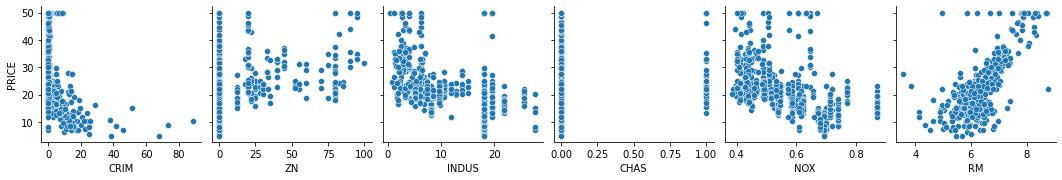

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt 
sns.pairplot(df, x_vars=df.columns[0:6], y_vars=['PRICE'])
plt.show()

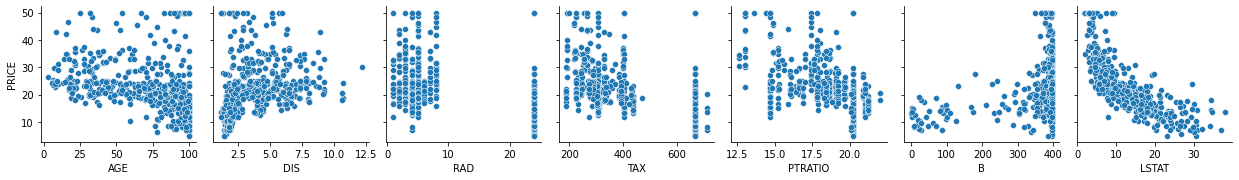

In [7]:
sns.pairplot(df, x_vars=df.columns[6:13], y_vars=['PRICE'])
plt.show()

明らかに相関があるのは`CRIM`, `RM`, `LSTAT`です。この3変数から住宅価格を予想するモデルを作ってみましょう。

In [8]:
data=df.loc[:,['CRIM','RM','LSTAT']].values
target=df['PRICE'].values

どのような形の配列になっているかを見てみましょう。

In [9]:
data.shape, target.shape

((506, 3), (506,))

さて、モデルの構築ですが、まずは線形回帰モデルを試しましょう。

$$
y=ax_1+bx_2+cx_3
$$

のように3つの変数の線形和で価格が書けると考え、a,b,cの最適な値を最小二乗法で求めるという方法です。これも広義での機械学習に相当します。

最適化した値が、学習に使ったデータ以外でも妥当なものかどうか（汎化性能）は機械学習タスクにおいてとても重要です。なので、事前に学習するデータと検証に使うデータを分けることを行います。
今回は1/4のデータを検証用に取っておきます。

In [10]:
from sklearn.model_selection import train_test_split

#random_state=0で乱数のシードを固定しています
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.25, random_state=0)

線形回帰モデルを定義して`fit`で学習させます。

In [11]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

学習済みモデルの`predict`を使って、取っておいた検証データを使った予測価格を計算します。

In [12]:
y_pred=model.predict(X_test)

実際の値と予測値はどの様になっているでしょうか

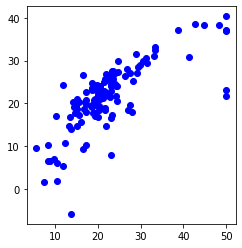

In [13]:
plt.axes().set_aspect('equal')
plt.scatter(y_test,y_pred,c='blue')

当てずっぽうよりは良いようだが…という感じですね。どれぐらい妥当なのかどうかを定量的に評価しましょう。代表的な評価指数としては、MSE（最小二乗誤差)が挙げられます

In [14]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, y_pred)

35.96179836034815

もう一つは決定係数$R^2$です

$$
R^2=1-\frac{\sum_i (y_i-f_i)}{\sum_j (y_j-\bar{y})}
$$

$f_i$はモデルの予想値で、$y_i$が実際の値です。直感的には全部平均値で予想したときよりどれぐらいあたっているかということに相当しています。１に近いほど当てはまりが良いことを示しています。scikit-learnで作ったモデルにはscoreというメソッドがだいたい実装されていて、それを使うことでこの決定係数を計算できます

In [15]:
model.score(X_test, y_test)

0.5598258049067267

うーん、微妙ですね。

予測モデルを向上することを考えましょう。できそうなことは、使う変数を増やすこと、高度なモデルを使うこと、データに前処理を行うことです。

前処理+変数を増やすを試してみましょう。

たとえば`CRIM`のデータは他より随分値が小さいのですが、このようにそれぞれの変数の大きさがあまりに違ってしまうと、機械学習モデルはうまく予想できないことが多々あります。大きさが大体同じぐらいになるように、変数ごとに正規化することが前処理としてよく行われます。

代表的な平均０分散１になるような正規化を行ってみましょう。

In [16]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
df_scaled=df.copy()
df_scaled.iloc[:,0:-1]=scaler.fit_transform(df.iloc[:,0:-1])

In [17]:
df_scaled.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,-0.419782,0.284830,-1.287909,-0.272599,-0.144217,0.413672,-0.120013,0.140214,-0.982843,-0.666608,-1.459000,0.441052,-1.075562,24.0
1,-0.417339,-0.487722,-0.593381,-0.272599,-0.740262,0.194274,0.367166,0.557160,-0.867883,-0.987329,-0.303094,0.441052,-0.492439,21.6
2,-0.417342,-0.487722,-0.593381,-0.272599,-0.740262,1.282714,-0.265812,0.557160,-0.867883,-0.987329,-0.303094,0.396427,-1.208727,34.7
3,-0.416750,-0.487722,-1.306878,-0.272599,-0.835284,1.016303,-0.809889,1.077737,-0.752922,-1.106115,0.113032,0.416163,-1.361517,33.4
4,-0.412482,-0.487722,-1.306878,-0.272599,-0.835284,1.228577,-0.511180,1.077737,-0.752922,-1.106115,0.113032,0.441052,-1.026501,36.2


In [18]:
data=df_scaled.loc[:,['CRIM','RM','LSTAT','ZN','AGE','DIS','NOX','RAD','PTRATIO']].values
target=df_scaled['PRICE'].values
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.25, random_state=0)

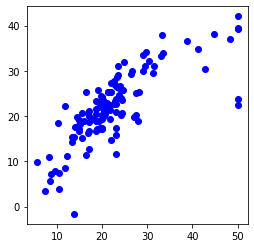

In [19]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred=model.predict(X_test)
plt.axes().set_aspect('equal')
plt.scatter(y_test,y_pred,c='blue')

In [20]:
mean_squared_error(y_test, y_pred)

32.08436392069654

In [21]:
model.score(X_test, y_test)

0.6072857947103084

ちょっと向上しました

線形モデルの限界を感じるのでもうちょっと高度なモデルを試しましょう。有名なものとしてはサポートベクターマシン(SVR)やランダムフォレストなどがあります。

まずはサポートベクターマシンから

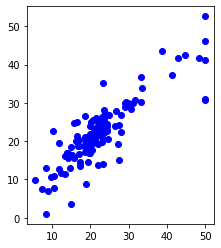

In [22]:
from sklearn.svm import SVR
model=SVR(kernel='rbf', C=1e3, gamma=0.1, epsilon=0.1)
model.fit(X_train,y_train)
y_pred=model.predict(X_test)
plt.axes().set_aspect('equal')
plt.scatter(y_test,y_pred,c='blue')


In [23]:
mean_squared_error(y_test, y_pred)

21.47186707901055

In [24]:
model.score(X_test, y_test)

0.7371832822722684

だいぶ良いですね

次にランダムフォレストを使ってみましょう。

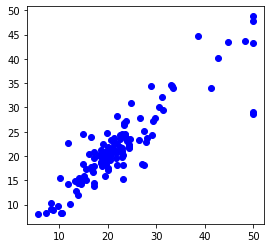

In [25]:
from sklearn.ensemble import RandomForestRegressor
model=RandomForestRegressor()
model.fit(X_train,y_train)
y_pred=model.predict(X_test)
plt.axes().set_aspect('equal')
plt.scatter(y_test,y_pred,c='blue')

In [26]:
mean_squared_error(y_test, y_pred)

16.888290700787394

In [27]:
model.score(X_test, y_test)

0.7932864844179517

モデルの選択やデータの処理方法で予測性能が大きく変わってくることが実感できると思います。